In [7]:
import os
import git
import sys
from joblib import Parallel, delayed

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

sys.path.append(git_root)

from abm_vec.abm_simulation import run_simulation
from abm_vec.initialization import get_bank_data
from scipy.optimize import minimize
from scipy.stats import kstest
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from abm_vec.essentials.util import get_git_root_directory
import numpy as np
import random
from scipy import stats

In [8]:
bank_data = get_bank_data()

In [9]:
len(bank_data['equity'])

80

# Minimize the KS distance first

In [10]:
def fun(x):

    param = {'firm_lb1': x[0],
             'firm_lb2': x[1],
             'firm_ub1': x[2],
             'firm_ub2': x[3],
             'firm_alpha1': x[4],
             'firm_alpha2': x[5],
             'firm_rho': x[6],
             'min_productivity': x[7]}
    results = run_simulation(1, copy.deepcopy(bank_data), param) 
    max_diff = kstest(results[0], results[1], alternative='two-sided').statistic 
    return max_diff

In [11]:
bounds = [(5 * 10 ** 5, 5 * 10 ** 6),
          (10 ** 3, 10**4),
          (5 * 10** 7, 30 * 10 ** 7),
          (5 * 10 ** 5, 10 ** 7),
          (0, 3),
          (0, 3),
          (0, 1) ,
          (100, 1000)]#,
          #(50, 2000)]

initial_guess = [10**6, 7500, 15 * 10 ** 7, 0.7 * 10 ** 6, 1.6, 1.7, 0.9, 150]#, 820]


result = minimize(fun, initial_guess, method='Nelder-Mead', bounds=bounds)

In [12]:
optimal_x = result.x

In [13]:
optimal_x

array([9.87030029e+05, 7.81471252e+03, 1.51020813e+08, 6.98611450e+05,
       1.66713867e+00, 1.66508484e+00, 9.37765503e-01, 1.40844727e+02])

In [14]:
result.fun

0.1125

# Generate 1000 samples and apply the k-sample Anderson test

In [15]:
def fun(seed=1, bank_data=None):

    param = {'firm_lb1': optimal_x[0],
             'firm_lb2': optimal_x[1],
             'firm_ub1': optimal_x[2],
             'firm_ub2': optimal_x[3],
             'firm_alpha1': optimal_x[4],
             'firm_alpha2': optimal_x[5],
             'firm_rho': optimal_x[6],
             'min_productivity': optimal_x[7],}
             #'market_price': optimal_x[8]}
    res = run_simulation(seed, copy.deepcopy(bank_data), param)
    return res


random_seeds = random.sample(range(1, 100000), 1000)

results = Parallel(n_jobs=-1)(delayed(fun)(i, bank_data) for i in random_seeds)

In [23]:
# save data to pickle 
import pickle

with open('filename.pickle', 'wb') as handle:
    pickle.dump((results, random_seeds, optimal_x), handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
# Anderson k-sample test

In [25]:
from scipy.stats import anderson_ksamp

In [26]:
res = anderson_ksamp([x[1] for x in results])

/var/folders/c9/mdyn5q915qzdd068w6dx1gbm0000gp/T/ipykernel_8205/222184903.py:1: UserWarning: p-value capped: true value larger than 0.25
  res = anderson_ksamp([x[1] for x in results])


In [18]:
res.pvalue

0.25

In [19]:
# KS independent

In [20]:
# ks test
res = [kstest(r[0], r[1], alternative='two-sided').pvalue for r in results]

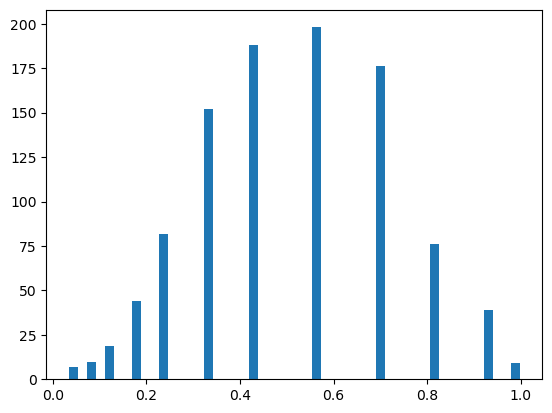

In [21]:
plt.hist(res, bins=50)
plt.show()

# price distribution

In [27]:
new_firm_market_price = [np.average(x[4]) for x in results]
old_market_price = [x[5] for x in results]

(array([  8.,  18.,  71., 147., 229., 272., 160.,  68.,  22.,   5.]),
 array([347.13822641, 348.79934725, 350.46046809, 352.12158893,
        353.78270977, 355.4438306 , 357.10495144, 358.76607228,
        360.42719312, 362.08831396, 363.74943479]),
 <BarContainer object of 10 artists>)

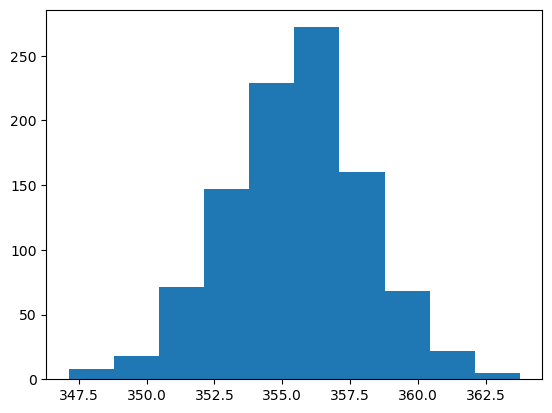

In [29]:
plt.hist(new_firm_market_price)

In [ ]:
y